In [ ]:
import itertools as it
import pickle
import re
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS

from entitybert.latex import dataframe_to_latex
from entitybert.selection import EntityTree, open_db
from entitybert.semantic import find_method_docs

In [2]:
sns.set_theme(style="whitegrid")

In [3]:
def load_files(db_path: str, filenames: list[str]) -> list[str]:
    with open_db(db_path) as conn:
        trees = EntityTree.load_from_db(conn.cursor())
    contents = []
    for filename in filenames:
        contents.append(trees[filename].text())
    return contents


def clean_whitespace(text: str) -> str:
    return re.sub(r"\s+", " ", text)


def normalize_vectors(X: np.ndarray) -> np.ndarray:
    """Normalize each vector in X to have a unit length, handle zero-norm vectors."""
    norms = np.linalg.norm(X, axis=1, keepdims=True)

    # Prevent division by zero by replacing zero norms with 1 (to avoid NaNs)
    norms[norms == 0] = 1

    return X / norms

In [4]:
# Load files created by recovery.py
df = pd.read_csv("_data/recovery.csv", index_col=0)

with open("_data/recovery_state.pkl", "rb") as f:
    state = pickle.load(f)

tests: dict[str, dict[int, list[list[str]]]] = state["tests"]
filenames: dict[str, list[str]] = state["filenames"]
lsi_embeddings: dict[str, dict[int, dict[str, np.ndarray]]] = state["lsi_embeddings"]
d2v_embeddings: dict[str, dict[int, dict[str, np.ndarray]]] = state["d2v_embeddings"]
bert_embeddings: dict[str, dict[str, np.ndarray]] = state["bert_embeddings"]

# Split "model" into "model" and "dim"
df["model"] = df["model"].astype(str)
df[["model", "dim"]] = df["model"].str.split("-", n=1, expand=True)
df["dim"] = pd.to_numeric(df["dim"], errors="coerce").fillna(768).astype(int)
columns = list(df.columns)
model_index = columns.index("model")
new_order = columns[: model_index + 1] + ["dim"] + columns[model_index + 1 : -1]
df = df[new_order]

In [5]:
n_files = len(list(it.chain(*filenames.values())))
print(f"# of Files: {n_files}")

# of Files: 39723


In [6]:
counts = Counter()

for db_path in tests:
    for group_size in [2, 3, 4, 5]:
        counts[group_size] += len(tests[db_path][group_size])

counts

Counter({2: 19791, 3: 13082, 4: 9819, 5: 7820})

In [7]:
grouped_df = df.groupby(["model", "dim", "group_size"])["nmi"].mean().reset_index()
summary_df = grouped_df.pivot_table(
    index=["model", "dim"], columns="group_size", values="nmi"
).reset_index()
summary_df.columns = ["Model", "Dim.", "NMI-2", "NMI-3", "NMI-4", "NMI-5"]
summary_df

,Model,Dim.,NMI-2,NMI-3,NMI-4,NMI-5
0,BERT,768,0.735239,0.722193,0.728143,0.735677
1,D2V,10,0.286060,0.333101,0.366601,0.391902
2,D2V,64,0.300569,0.341636,0.373838,0.398578
3,D2V,256,0.299014,0.340278,0.372906,0.396579
4,D2V,768,0.298382,0.339633,0.372671,0.396940
5,LSI,10,0.465199,0.492258,0.513691,0.527111
6,LSI,64,0.562609,0.571496,0.587107,0.598689
7,LSI,256,0.581331,0.587853,0.604051,0.616934
8,LSI,768,0.577928,0.586364,0.604099,0.617025


In [8]:
pair_tests = []

for (db_path, group_i), _ in df[df["group_size"] == 2].groupby(["db_path", "group_i"]):
    group = tests[db_path][2][group_i]
    pair_tests.append([db_path] + group)

In [9]:
INDEX = 14933
SEED = 7

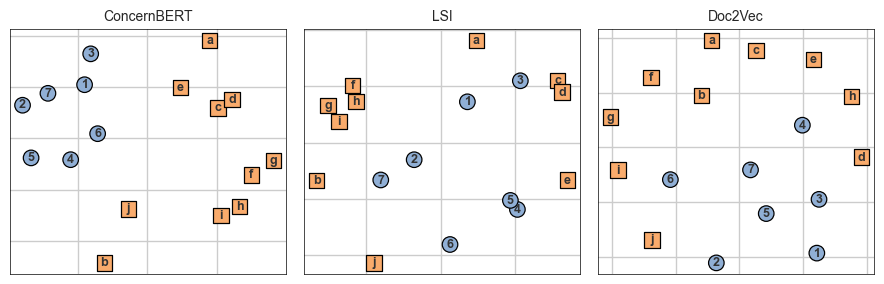

In [10]:
my_labels = None
point_labels = None
docs = None


# Function to plot the diagram
def plot_diagram(ax, db_path: str, group: list[str], model: str):
    texts = load_files(db_path, group)
    nested_docs = [
        [clean_whitespace(d.method_text) for d in find_method_docs(t)] for t in texts
    ]
    docs = list(it.chain(*nested_docs))

    # Dumb hack to get the emb_dict for a model name
    parts = model.split("-")
    normalize = True
    if len(parts) == 1:
        if parts[0].lower() == "bert":
            normalize = False
            emb_dict = bert_embeddings[db_path]
        else:
            raise RuntimeError
    elif len(parts) == 2:
        if parts[0].lower() == "lsi":
            emb_dict = lsi_embeddings[db_path][int(parts[1])]
        elif parts[0].lower() == "d2v":
            emb_dict = d2v_embeddings[db_path][int(parts[1])]
        else:
            raise RuntimeError()
    else:
        raise RuntimeError()

    # Plot
    embs: list[np.ndarray] = []
    labels: list[str] = []
    for i, filename in enumerate(group):
        emb = emb_dict[filename]
        embs.extend(emb)
        labels.extend([str(i)] * emb.shape[0])
    emb = np.vstack(embs)
    if normalize:
        emb = normalize_vectors(emb)
    emb_2d = MDS(random_state=SEED).fit_transform(emb)

    # lol
    point_labels = [
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "a",
        "b",
        "c",
        "d",
        "e",
        "f",
        "g",
        "h",
        "i",
        "j",
        "k",
    ]
    # point_labels = list(string.ascii_lowercase)

    marker_styles = {"0": "o", "1": "s"}
    marker_colors = {"0": "#90afd5", "1": "#f9ab6c"}

    # Adjust the offset for text labels
    x_offset = 0.0
    y_offset = -0.005

    # Add labels to each point first
    for i in range(emb_2d.shape[0]):
        ax.text(
            emb_2d[i, 0] + x_offset,  # Add the x offset
            emb_2d[i, 1] + y_offset,  # Add the y offset
            point_labels[i],
            fontsize=9,
            fontweight="bold",  # Make the text bold
            ha="center",
            va="center",
            color="#333333",  # Adjust the color if necessary
        )

    # Now plot the scatter plot after the text, so markers can overlap text if needed
    sns.scatterplot(
        x=emb_2d[:, 0],
        y=emb_2d[:, 1],
        hue=labels,
        style=labels,
        markers=marker_styles,
        palette=marker_colors,
        ax=ax,
        legend=False,
        edgecolor="black",
        s=125,
    )

    # Remove ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    global my_labels
    my_labels = labels
    global my_point_labels
    my_point_labels = point_labels
    global my_docs
    my_docs = docs


db_path, a, b = pair_tests[INDEX]
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plot_diagram(axes[0], db_path, [a, b], "BERT")
plot_diagram(axes[1], db_path, [a, b], "LSI-256")
plot_diagram(axes[2], db_path, [a, b], "D2V-256")

axes[0].set_title("ConcernBERT", fontsize=10)
axes[1].set_title("LSI", fontsize=10)
axes[2].set_title("Doc2Vec", fontsize=10)

for ax in axes.flat:
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(0.5)

plt.tight_layout()
fig.savefig("_data/embeddings.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
rows = []

def escape(text: str) -> str:
    text = text.replace("{", r"\{")
    text = text.replace("}", r"\}")
    text = text.replace("_", r"\_")
    return text


for i, label in enumerate(my_labels):
    letter = my_point_labels[i]
    limit = 80
    text = my_docs[i]
    if len(text) > limit:
        text = escape(text[:limit])
        text = f"\\texttt{{{text}...}}"
    else:
        text = escape(text)
        text = f"\\texttt{{{text}}}"
    rows.append({"Marker": letter, "Text": text})

text_df = pd.DataFrame.from_records(rows)
text_df

,Marker,Text
0,1,\texttt{public UriValue(LispTree tree) \{ this...
1,2,\texttt{public UriValue(String value) \{ this....
2,3,\texttt{public LispTree toLispTree() \{ LispTr...
3,4,\texttt{@Override public String sortString() \...
4,5,\texttt{@Override public String pureString() \...
5,6,\texttt{@Override public int hashCode() \{ ret...
6,7,\texttt{@Override public boolean equals(Object...
7,a,\texttt{public static KnowledgeGraph fromLispT...
8,b,"\texttt{public static List<Pair<Value, Value>>..."
9,c,\texttt{public abstract LispTree toLispTree();}


In [12]:
table = dataframe_to_latex(
    text_df, "Methods in Figure 1", "tbl:methods", col_format="r|l"
)
print(table)

\begin{table}
  \caption{Methods in Figure 1}
  \label{tbl:methods}
  \begin{tabular}{r|l}
    \toprule
    Marker & Text \\
    \midrule
    1 & \texttt{public UriValue(LispTree tree) \{ this.value = tree.child(1).value; \}} \\
    2 & \texttt{public UriValue(String value) \{ this.value = value; \}} \\
    3 & \texttt{public LispTree toLispTree() \{ LispTree tree = LispTree.proto.newList(); tree.ad...} \\
    4 & \texttt{@Override public String sortString() \{ return "" + value; \}} \\
    5 & \texttt{@Override public String pureString() \{ return "" + value; \}} \\
    6 & \texttt{@Override public int hashCode() \{ return value.hashCode(); \}} \\
    7 & \texttt{@Override public boolean equals(Object o) \{ if (this == o) return true; if (o ==...} \\
    a & \texttt{public static KnowledgeGraph fromLispTree(LispTree tree) \{ if ("graph".equals(tr...} \\
    b & \texttt{public static List<Pair<Value, Value>> getReversedPairs(Collection<Pair<Value, V...} \\
    c & \texttt{public abstra